# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

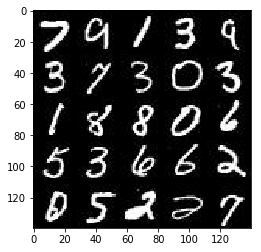

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

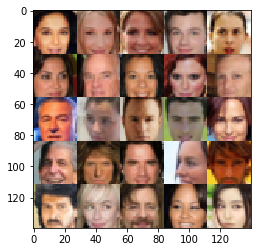

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real_image') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real_image, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Based on DCGAN exercise
    
    # Defining hyperparameters to use leaky ReLU's
    alpha = 0.2
    keep_prob = 0.9
    
    # Choosing kernel of size 5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannels
        # First layer does not have batch normalization nor dropout
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x128

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x256
        
        # using strides = 1 to void reshaping the 7x7 tensor
        x3 = tf.layers.conv2d(drop2, 512, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(drop3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Based on DCGAN exercise and discussions on Slack
    
    # Defining hyperparameters to use leaky ReLU's
    alpha = 0.2
    keep_prob = 0.9
    stddev = 0.05
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512*out_channel_dim)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512 * out_channel_dim))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu_1 = tf.maximum(alpha * bn1, bn1)
        # 7 x 7 x 512 x out_channel_dim now
        
        x2 = tf.layers.conv2d_transpose(relu_1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 14x14x256 x out_channel_dim now
        
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x2, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 28x28x128 x out_channel_dim now 
        
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # 28x28xout_channel_dim now
    
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Based on DCGAN exercise
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # saver = tf.train.Saver()
    # sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    # steps = 0
    
    print_every = 5
    show_every = 50
    
    n_images = 25
    
    inputs_real_image, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(inputs_real_image, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # print(data_shape[1], data_shape[2], data_shape[3])
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
            # TODO: Train Model
            
                steps = steps + 1
                
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real_image: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real_image: batch_images})

                if steps % print_every == 0:
                    # At the end of each 'print_every' epoch, get the losses and print them out
                    
                    train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real_image: batch_images})
                    train_loss_g = sess.run(g_loss, {inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    # gen_samples = sess.run(
                    #                generator(batch_z, data_shape[3], is_train=False),
                    #                feed_dict={input_z: batch_z})
                    # samples.append(gen_samples)
                    # _ = show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                    # plt.show()
                
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6755... Generator Loss: 3.2542
Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 15.1337
Epoch 1/2... Discriminator Loss: 9.6173... Generator Loss: 44.3449
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 7.3996
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 4.0446
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 7.5273
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 3.9440
Epoch 1/2... Discriminator Loss: 0.6644... Generator Loss: 4.0050
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 5.0815
Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 5.1282


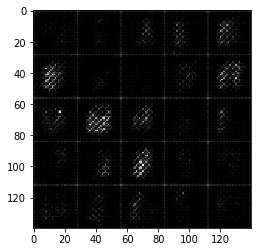

Epoch 1/2... Discriminator Loss: 0.7959... Generator Loss: 3.7369
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 1.3723
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 3.6149
Epoch 1/2... Discriminator Loss: 3.4135... Generator Loss: 7.0596
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 2.9427
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 3.9806
Epoch 1/2... Discriminator Loss: 2.2542... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 2.3858
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.9437


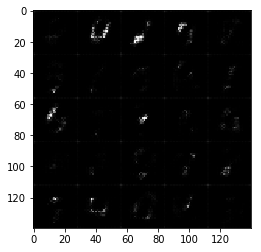

Epoch 1/2... Discriminator Loss: 2.3545... Generator Loss: 0.3132
Epoch 1/2... Discriminator Loss: 2.0078... Generator Loss: 3.9627
Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 3.0693
Epoch 1/2... Discriminator Loss: 2.5923... Generator Loss: 0.2603
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 1.7551
Epoch 1/2... Discriminator Loss: 2.3245... Generator Loss: 4.8133
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.9064
Epoch 1/2... Discriminator Loss: 1.7254... Generator Loss: 4.6580


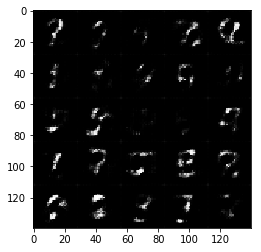

Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.5096
Epoch 1/2... Discriminator Loss: 1.9544... Generator Loss: 4.8262
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 2.1273
Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.9463
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.5027
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 3.0346
Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.4638
Epoch 1/2... Discriminator Loss: 1.9983... Generator Loss: 5.3993


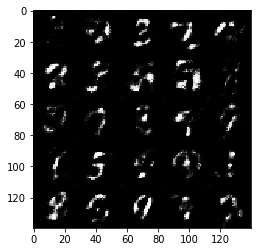

Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 2.2376... Generator Loss: 0.3212
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 2.3182
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 2.1159
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 4.0654
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 1.4003
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 1.7104
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 3.5467
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 3.9932
Epoch 1/2... Discriminator Loss: 0.6138... Generator Loss: 2.2744


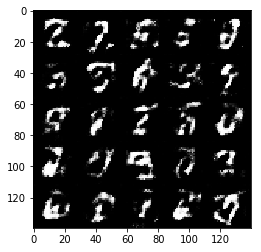

Epoch 1/2... Discriminator Loss: 2.0993... Generator Loss: 9.0577
Epoch 1/2... Discriminator Loss: 2.5638... Generator Loss: 7.2212
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 5.1875
Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 1.3422
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.8577
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 3.9197
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.7569... Generator Loss: 3.2505
Epoch 1/2... Discriminator Loss: 0.5639... Generator Loss: 1.9755


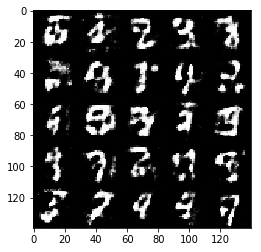

Epoch 1/2... Discriminator Loss: 2.2763... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 2.8693
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.4261
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 2.2603
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 1.9710
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 4.9499
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 1.1884
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 3.6588
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.8517


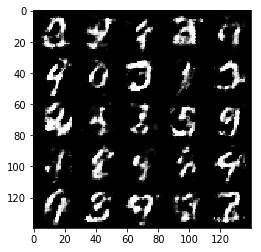

Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 5.1584
Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 3.2602... Generator Loss: 10.5280
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 1.3640
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 2.3569
Epoch 1/2... Discriminator Loss: 2.4788... Generator Loss: 0.3376
Epoch 1/2... Discriminator Loss: 0.8084... Generator Loss: 2.3124
Epoch 1/2... Discriminator Loss: 1.6143... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 2.0546


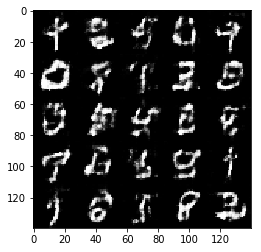

Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 3.8618
Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 1.8359
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 2.4417
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 5.4502
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.8653
Epoch 1/2... Discriminator Loss: 1.7141... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 1.1329


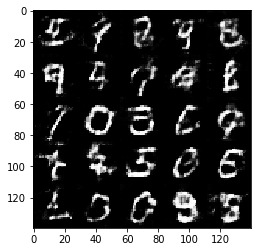

Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 2.0327
Epoch 1/2... Discriminator Loss: 1.5633... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 2.1953
Epoch 2/2... Discriminator Loss: 1.7353... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 3.1641
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.9381
Epoch 2/2... Discriminator Loss: 1.5748... Generator Loss: 4.2943
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 2.8946


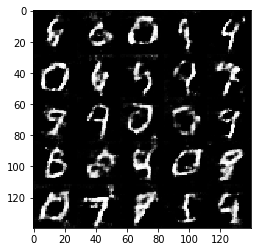

Epoch 2/2... Discriminator Loss: 1.7181... Generator Loss: 0.4873
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 3.0686
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.9244
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 2.1087... Generator Loss: 4.9411
Epoch 2/2... Discriminator Loss: 1.5935... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.9006
Epoch 2/2... Discriminator Loss: 1.7910... Generator Loss: 4.4755
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 1.7619
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.9635


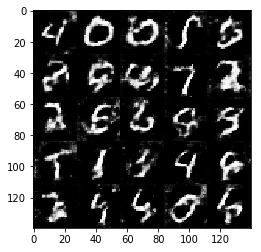

Epoch 2/2... Discriminator Loss: 3.5797... Generator Loss: 7.1500
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 2.2838
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.5823... Generator Loss: 3.9933
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 3.7390
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 2.2922
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.6015


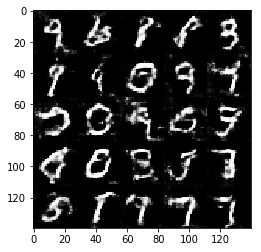

Epoch 2/2... Discriminator Loss: 1.8775... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 1.1793
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 3.4425
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.8036
Epoch 2/2... Discriminator Loss: 2.0454... Generator Loss: 0.3458
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 1.7259
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 0.9550
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 2.0533... Generator Loss: 0.4002
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.0741


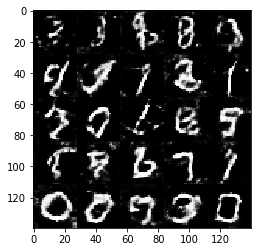

Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.8078
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 2.4639
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 2.1760
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.6638
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 3.3365
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 3.6803
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 1.0531


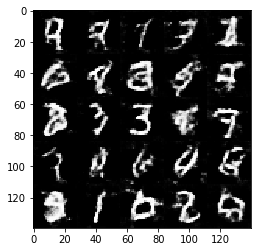

Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 3.8646
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.9953... Generator Loss: 0.4101
Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.1974
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 2.2702
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.9306
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.4457
Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 3.4531


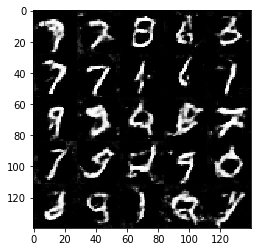

Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 0.8342... Generator Loss: 1.8134
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 3.0915
Epoch 2/2... Discriminator Loss: 1.5661... Generator Loss: 3.3329
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 1.6873
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 2.2887
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.5068


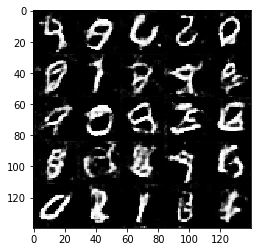

Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 1.2912
Epoch 2/2... Discriminator Loss: 1.6129... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 1.4995... Generator Loss: 4.3013
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 2.4406
Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 1.8237
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 4.2145
Epoch 2/2... Discriminator Loss: 2.0717... Generator Loss: 4.9019
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 4.2602
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.4116


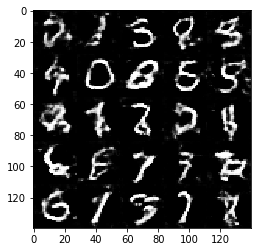

Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 1.3908
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 2.0394
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 4.1386
Epoch 2/2... Discriminator Loss: 3.6509... Generator Loss: 0.1485
Epoch 2/2... Discriminator Loss: 1.7093... Generator Loss: 0.5312
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 1.9394
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.3980


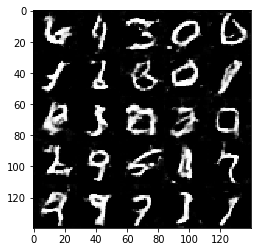

Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 2.5024
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.5257
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 4.2576
Epoch 2/2... Discriminator Loss: 2.1358... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.6293... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 0.9077


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5

# import helper

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3711... Generator Loss: 2.3844
Epoch 1/1... Discriminator Loss: 5.9906... Generator Loss: 18.8270
Epoch 1/1... Discriminator Loss: 1.8910... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 1.7726
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 2.5301
Epoch 1/1... Discriminator Loss: 0.5635... Generator Loss: 3.1561
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.5580
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 4.0712


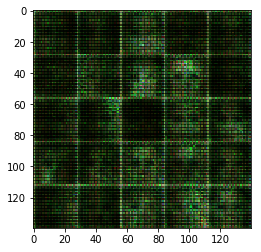

Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 5.0935
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 4.7929
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 6.5604
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 2.7526
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.5194
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.3922
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 2.9952
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 3.9230
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 3.4853
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 5.1816


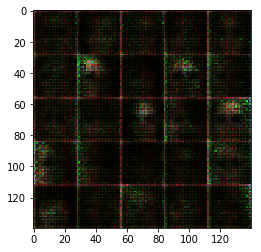

Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 4.0957
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 5.9928
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 4.4046
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 5.7753
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 3.3076
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 6.2846
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 3.5950
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 4.7640
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.6934
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 4.2235


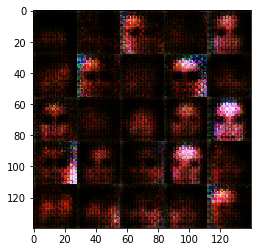

Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 2.8114
Epoch 1/1... Discriminator Loss: 5.2557... Generator Loss: 13.2063
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 4.4278
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 4.1843
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 4.4755
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 8.0841
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 5.5253
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 2.2510
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 4.7860
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 5.7142


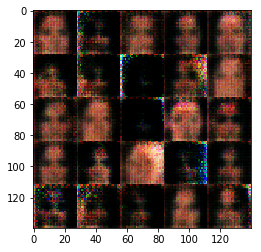

Epoch 1/1... Discriminator Loss: 3.5637... Generator Loss: 10.4471
Epoch 1/1... Discriminator Loss: 4.1340... Generator Loss: 0.0814
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 2.3198
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 2.2310
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 2.1142
Epoch 1/1... Discriminator Loss: 2.1054... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.2476
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 3.4913
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.8024


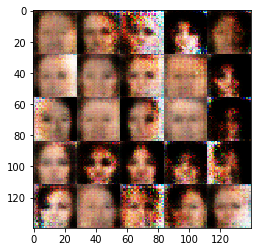

Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 2.4770
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 5.2186
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 3.0157
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 3.1828
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.5611
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 4.3906
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.7324


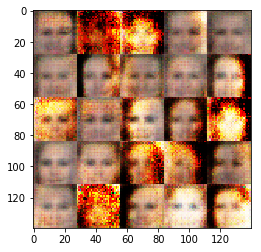

Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.8242
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 2.3211
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 3.1580
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.4869
Epoch 1/1... Discriminator Loss: 2.1885... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.6983


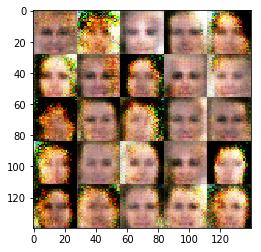

Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 3.8593
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 4.1083
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 3.9199
Epoch 1/1... Discriminator Loss: 1.7248... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.7981
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 2.3723


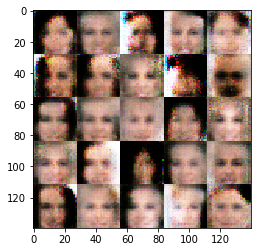

Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 3.1714
Epoch 1/1... Discriminator Loss: 8.8950... Generator Loss: 10.6269
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 2.2684... Generator Loss: 0.2540
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.7965


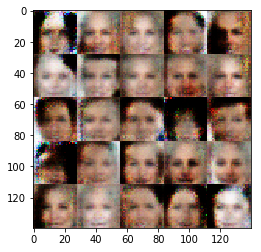

Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 2.0832
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.6010
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 1.7933
Epoch 1/1... Discriminator Loss: 2.4391... Generator Loss: 5.6854
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 3.1845
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 1.8129


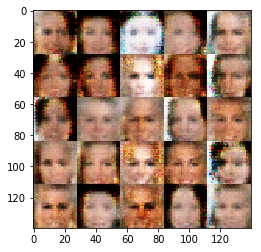

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.8827
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 2.8960
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 3.7684
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 3.2979
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.6500
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 3.2530
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7709


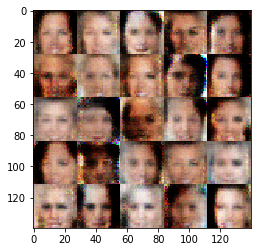

Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 2.1629... Generator Loss: 0.2448
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 2.7085
Epoch 1/1... Discriminator Loss: 2.7244... Generator Loss: 4.5855
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.8011
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 1.0397


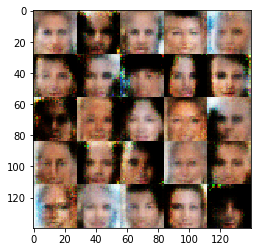

Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 0.3789
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 2.5566
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 3.2639... Generator Loss: 4.7778
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 2.8369
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.6435


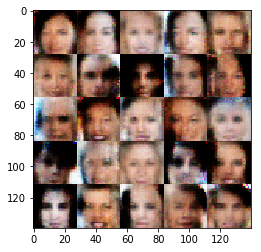

Epoch 1/1... Discriminator Loss: 2.4208... Generator Loss: 0.2306
Epoch 1/1... Discriminator Loss: 1.7335... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 2.4806
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 4.3175
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 3.1238
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 2.1656


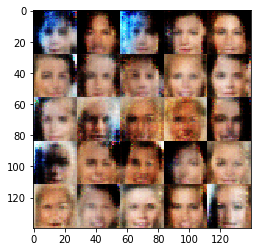

Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 2.8194
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 5.5536
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 4.3312
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 2.4047
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.1564
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.8402


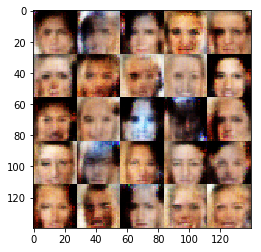

Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 3.0394
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 3.0914
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 4.4261
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 2.0860


In [13]:
batch_size = 256
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.